In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from pycaret.regression import *
from pycaret.classification import *
from pycaret.time_series import *
import hvplot.pandas


In [35]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [36]:
#Getting BTC Dataframe

# Define the ticker symbol for Bitcoin
btc_symbol = "BTC-USD"

# Specify the date range for the past 10 years
start_date = "2013-10-09"
end_date = "2023-12-04"

# Use yfinance to get Bitcoin data for the specified date range
btc_data = yf.download(btc_symbol, start=start_date, end=end_date, progress=False)

# Extract the "Close" column and create a DataFrame
btc_df = btc_data[["Close"]]

# Print the first few rows of the DataFrame
print(btc_df.head())
print(btc_df.tail())

                 Close
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014
                   Close
Date                    
2023-11-29  37858.492188
2023-11-30  37712.746094
2023-12-01  38688.750000
2023-12-02  39476.332031
2023-12-03  39978.390625


In [37]:
# Plot the closing prices for Bitcoin
btc_df.hvplot.line(
    title="Bitcoin Closing Prices",
    xlabel="Date",
    ylabel="Closing Price ($)",
    width=1000,
    height=400,
)



:Curve   [Date]   (Close)

In [38]:
# Preprocessing Data
bitcoin_data = btc_df.copy()
bitcoin_data = bitcoin_data.dropna()
bitcoin_data.head()

Close
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014

In [7]:
# Display the last five rows of the Bitcoin price DataFrame
bitcoin_data.tail()

Close
Date                    
2023-11-29  37858.492188
2023-11-30  37712.746094
2023-12-01  38688.750000
2023-12-02  39476.332031
2023-12-03  39978.390625

In [39]:
# Normalizing BTC Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(btc_df["Close"].values.reshape(-1, 1))

In [40]:
# Prepare the data for LSTM
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i : (i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

In [10]:
# Reshape the data
X = X.reshape((X.shape[0], X.shape[1], 1))

In [11]:
# Spit the data into training and testing
train_size = int(len(y) * 0.80)
test_size = len(scaled_data) - train_size
train_data, test_data = X[0:train_size, :], X[train_size : len(scaled_data), :]

In [12]:
# Reshape into X_train and y_train
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)




In [13]:
# Building the LSTM Model
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=30))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=10, batch_size=32) #Change epochs to 100 for better results


# Summarize the model
model.summary()

Epoch 1/10
79/79 [==============================] - 3s 19ms/step - loss: 0.0057
Epoch 2/10
79/79 [==============================] - 1s 18ms/step - loss: 7.4373e-04
Epoch 3/10
79/79 [==============================] - 1s 19ms/step - loss: 6.1785e-04
Epoch 4/10
79/79 [==============================] - 1s 19ms/step - loss: 5.7610e-04
Epoch 5/10
79/79 [==============================] - 1s 19ms/step - loss: 5.0423e-04
Epoch 6/10
79/79 [==============================] - 1s 19ms/step - loss: 4.2692e-04
Epoch 7/10
79/79 [==============================] - 1s 19ms/step - loss: 4.5188e-04
Epoch 8/10
79/79 [==============================] - 1s 19ms/step - loss: 3.8982e-04
Epoch 9/10
79/79 [==============================] - 1s 18ms/step - loss: 3.4550e-04
Epoch 10/10
79/79 [==============================] - 1s 18ms/step - loss: 3.8395e-04
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM

In [14]:
# Predicting BTC Prices
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)

18/18 [==============================] - 0s 6ms/step


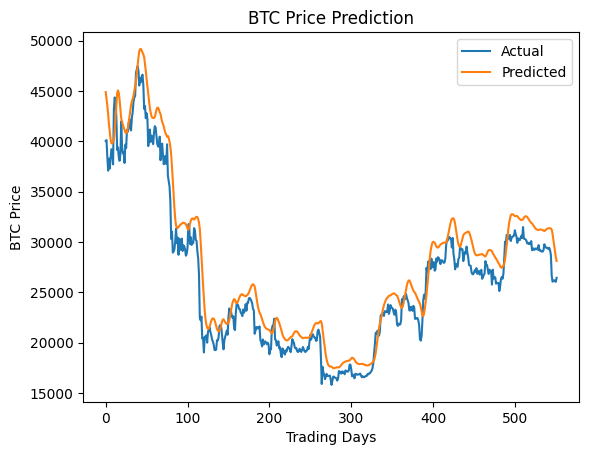

In [15]:
# Visualize the predicted prices
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)))
plt.plot(predicted_prices)
plt.title("BTC Price Prediction")
plt.xlabel("Trading Days")
plt.ylabel("BTC Price")
plt.legend(["Actual", "Predicted"])
plt.show()


In [16]:
# Applying Moving Averages (MA) strategy and backtesting
# Create a new empty DataFrame called `signals`
signals_df = pd.DataFrame(index=btc_df.index)

In [17]:
# Set the signal column to 0.0
signals_df["signal"] = 0.0


In [18]:
# Set the short window and long windows
short_window = 50
long_window = 100

# Generate the short and long moving averages (50 and 100 days, respectively)
signals_df["SMA50"] = btc_df["Close"].rolling(window=short_window).mean()
signals_df["SMA100"] = btc_df["Close"].rolling(window=long_window).mean()

In [19]:
# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
signals_df["signal"][short_window:] = np.where(
    signals_df["SMA50"][short_window:] > signals_df["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
signals_df["entry/exit"] = signals_df["signal"].diff()

# Print the DataFrame
print(signals_df.head())
print(signals_df.tail())

            signal  SMA50  SMA100  entry/exit
Date                                         
2014-09-17     0.0    NaN     NaN         NaN
2014-09-18     0.0    NaN     NaN         0.0
2014-09-19     0.0    NaN     NaN         0.0
2014-09-20     0.0    NaN     NaN         0.0
2014-09-21     0.0    NaN     NaN         0.0
            signal         SMA50        SMA100  entry/exit
Date                                                      
2023-11-29     1.0  34112.398086  30356.228164         0.0
2023-11-30     1.0  34329.186602  30473.039062         0.0
2023-12-01     1.0  34567.825625  30595.610156         0.0
2023-12-02     1.0  34820.104766  30728.749746         0.0
2023-12-03     1.0  35082.438438  30868.056973         0.0


In [20]:
# Visualize exit position 
exit = signals_df[signals_df['entry/exit'] == -1.0]['signal'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position
entry = signals_df[signals_df['entry/exit'] == 1.0]['signal'].hvplot.scatter(
    color='green',
    marker='^',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = btc_df['Close'].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)


:Overlay
   .Curve.Close       :Curve   [Date]   (Close)
   .NdOverlay.I       :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Signal.I  :Scatter   [Date]   (signal)
   .Scatter.Signal.II :Scatter   [Date]   (signal)

Create a backtest for a strategy.

In [21]:
from pyalgotrade.technical import ma
from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.stratanalyzer import returns, sharpe, drawdown, trades



In [ ]:
# Backtesting the trading strategy using pyalgotrade
class MovingAverageStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(MovingAverageStrategy, self).__init__(feed, 1000)
        self.__instrument = instrument
        self.__position = None
        self.setUseAdjustedValues(True)
        self.__prices = feed[instrument].getPriceDataSeries()
        self.__sma = ma.SMA(self.__prices, smaPeriod)
        self.__returns = returns.Returns()
        self.attachAnalyzer(self.__returns)
        self.__sharpe = sharpe.SharpeRatio()
        self.attachAnalyzer(self.__sharpe)
        self.__drawDown = drawdown.DrawDown()
        self.attachAnalyzer(self.__drawDown)
        self.__trades = trades.Trades()
        self.attachAnalyzer(self.__trades)

    def getSMA(self):
        return self.__sma

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        self.info("Exit position: %s" % (position.getExitOrder().getExecutionInfo().getPrice()))
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        # Wait for enough bars to be available to calculate a SMA.
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]
        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if bar.getPrice() > self.__sma[-1]:
                # Enter a buy market order for 10 shares. The order is good till canceled.
                self.info("Entry signal. Buy 10 shares at %s" % (bar.getPrice()))
                self.__position = self.enterLong(self.__instrument, 10, True)
        # Check if we have to exit the position.
        elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():
            self.info("Exit signal. Sell 10 shares at %s" % (bar.getPrice()))
            self.__position.exitMarket()


# Download the feed from Yahoo Finance.
feed = yahoofeed.Feed()
feed.addBarsFromCSV("btc", "BTC-USD.csv")

# Evaluate the strategy with the feed's bars.
myStrategy = MovingAverageStrategy(feed, "btc", 50)
myStrategy.run()

In [24]:
# Print the first lines of `portfolio`
print(portfolio.head())

            BTC-USD  holdings      cash     total  returns
Date                                                      
2014-09-17      0.0       0.0  100000.0  100000.0      NaN
2014-09-18      0.0       0.0  100000.0  100000.0      0.0
2014-09-19      0.0       0.0  100000.0  100000.0      0.0
2014-09-20      0.0       0.0  100000.0  100000.0      0.0
2014-09-21      0.0       0.0  100000.0  100000.0      0.0


In [25]:
# Print the last lines of `portfolio`
print(portfolio.tail())

                 BTC-USD      holdings          cash         total   returns
Date                                                                        
2023-11-29  3.785849e+06  3.785849e+06 -1.237568e+06  2.548282e+06  0.001077
2023-11-30  3.771275e+06  3.771275e+06 -1.237568e+06  2.533707e+06 -0.005719
2023-12-01  3.868875e+06  3.868875e+06 -1.237568e+06  2.631307e+06  0.038521
2023-12-02  3.947633e+06  3.947633e+06 -1.237568e+06  2.710066e+06  0.029931
2023-12-03  3.997839e+06  3.997839e+06 -1.237568e+06  2.760271e+06  0.018526


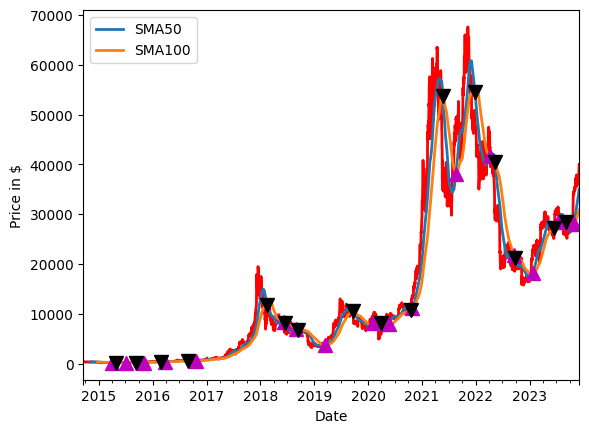

AttributeError: 'DataFrame' object has no attribute 'entry'

In [27]:
# Applying the backtesting strategy
# Create a figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, ylabel='Price in $')

# Plot the closing price
btc_df['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals_df[['SMA50', 'SMA100']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals_df.loc[signals_df['entry/exit'] == 1.0].index,
         signals_df['SMA50'][signals_df['entry/exit'] == 1.0],
         '^', markersize=10, color='m')

# Plot the sell signals
ax1.plot(signals_df.loc[signals_df['entry/exit'] == -1.0].index,
         signals_df['SMA50'][signals_df['entry/exit'] == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()
signals_df[['SMA50', 'SMA100']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals_df.loc[signals_df.entry/exit == 1.0].index,
         signals_df.SMA50[signals_df.entry/exit == 1.0],
         '^', markersize=10, color='m')

# Plot the sell signals
ax1.plot(signals_df.loc[signals_df.entry/exit == -1.0].index,
         signals_df.SMA50[signals_df.entry/exit == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

In [ ]:
# Calculating cumulative returns
cumulative_returns = (1 + portfolio["returns"]).cumprod() - 1
cumulative_returns.head()

In [ ]:
cumulative_returns.tail()

In [ ]:
# Plot cumulative returns
cumulative_returns.hvplot(
    title="Cumulative Returns",
    xlabel="Date",
    ylabel="Returns",
    width=1000,
    height=400,
)


In [ ]:
# Output performance metrics
# Calculate the annualized Sharpe Ratio
sharpe_ratios = (portfolio["returns"].mean() * 252) / (portfolio["returns"].std() * np.sqrt(252))
sharpe_ratios




In [ ]:
# Calculate the annualized volatility
annualized_volatility = portfolio["returns"].std() * np.sqrt(252)
annualized_volatility



In [ ]:
# Calculate the annualized average return
average_annual_return = portfolio["returns"].mean() * 252
average_annual_return

In [ ]:
# Calculate the cumulative return
cumulative_return = (portfolio["total"][-1] - portfolio["total"][0]) / portfolio["total"][0]
cumulative_return

In [ ]:
# Print the metrics
print(f"Sharpe Ratios: {sharpe_ratios}")
print(f"Annualized Volatility: {annualized_volatility}")
print(f"Average Annual Return: {average_annual_return}")
print(f"Cumulative Return: {cumulative_return}")
